In [156]:
import tensorflow as tf
import numpy as np
import random
import gym
import math
import matplotlib.pyplot as plt

class ReinforceAgent():
    def __init__(self,env,optimizer,learning_rate,value_optimizer):
        n_input = env.observation_space.shape[0]
        n_output = env.action_space.n
        self.sess = tf.Session()
        
        epsilon = 1e-8
        
        with tf.variable_scope("policy",reuse=True):
            #Variables: State , action and advantage
            self.state= state = tf.placeholder("float32",[None,n_input],name="state")
            self.action = action = tf.placeholder("float32",[None,n_output],name="action")
            self.adv = adv = tf.placeholder("float32",[None,1],name="advantage")
            
            #parameter of the network
            self.weights = weights = tf.Variable(tf.random_normal([n_input,n_output], stddev=0.01),name="weight" )
            self.phi = phi = tf.matmul(state,weights)
            self.action_prob = action_prob = tf.nn.softmax(phi)
            
            # Add a small value to prob for tf.log
            self.prob_for_action = prob_for_action = tf.reduce_sum(tf.mul(action_prob+epsilon, action),1)
            
            # Surrogate Loss: https://rllab.readthedocs.io/en/latest/user/implement_algo_basic.html 
            self.loss= loss = -tf.reduce_sum(tf.log(prob_for_action) * adv)
            self.optimizer = optimizer(learning_rate).minimize(self.loss)
        
        
        with tf.variable_scope("value",reuse=True):
            #Variables: State , value
            self.state_value = state_value = tf.placeholder("float32",[None,n_input],name="state_value")
            self.value_actual = value_actual = tf.placeholder("float32",[None,1],name="value")
            
            #parameter of the network
            self.weights_value = weights_value = tf.Variable(tf.random_normal([n_input,1], stddev=0.01),
                                                             name="weight2" )
            self.y = y = tf.matmul(state_value,weights_value)
            
            self.value_loss = tf.reduce_sum(tf.pow(value_actual-y, 2))
            self.value_optimizer = value_optimizer(learning_rate).minimize(self.value_loss)
            
        
            
            #initialize the variables
            self.sess.run(tf.initialize_all_variables())

    def create_trajectories(self,env,gamma,horizon = 200,T=10):
        
        states = []
        actions = []
        advantage = []
        all_rewards = []
        
        for j in xrange(T):
            trajectory = []
            total_reward = 0
            observation = env.reset()
            #Collect the trajectories 
            for i in xrange(horizon):
                observation_vector = np.expand_dims(observation, axis=0)
                old_observation = observation
                states.append(old_observation)

                act_probs = self.sess.run(self.action_prob,feed_dict={self.state: observation_vector})

                action_onehot = np.random.multinomial(1,act_probs[0])
                actions.append(action_onehot)
                action = list(action_onehot).index(1)
                observation, reward, done, info = env.step(action)
                trajectory.append((old_observation, action, reward))
                total_reward += reward

                if done:
                    break
            all_rewards.append(total_reward)
            return_so_far = 0.0
            adv = []
            for t in xrange(len(trajectory) - 1, -1, -1):
                obs, action, reward = trajectory[t]
                return_so_far = reward + gamma * return_so_far
                adv.append(return_so_far)
            for a in adv[::-1]:
                advantage.append(a)
                
            #print "Advantage",advantage
            # Find the value estimate
            value = self.sess.run(self.y,feed_dict={rf.state_value: states, rf.value_actual: np.expand_dims(advantage, axis=1)})
            baseline = []
            for each in value:
                baseline.append(each[0])
            #print "Value",value
            advantage_list = np.subtract(advantage , baseline)
            #print advantage_list 
            
            #Normalizing the once the advantage is calculated..
            advantage_list = (advantage_list - np.mean(advantage_list)) / (np.std(advantage_list) + 1e-8)
            advantage_vector = np.expand_dims(advantage_list, axis=1)
            

        return states,actions,advantage_vector,all_rewards
    def create_trajectory(self,env,gamma,horizon):
        return self.create_trajectories(env,gamma,horizon,T=1)


[2016-08-30 16:57:54,338] Making new env: CartPole-v0


0 [12.0, 17.0, 58.0, 35.0, 22.0, 34.0, 19.0, 29.0, 13.0, 14.0]
100 [12.0, 22.0, 24.0, 15.0, 13.0, 22.0, 13.0, 15.0, 17.0, 17.0]
200 [13.0, 39.0, 40.0, 27.0, 12.0, 32.0, 25.0, 20.0, 15.0, 20.0]
300 [37.0, 27.0, 26.0, 24.0, 11.0, 37.0, 14.0, 18.0, 34.0, 20.0]
400 [18.0, 18.0, 26.0, 13.0, 37.0, 15.0, 60.0, 21.0, 43.0, 12.0]


[2016-08-30 16:58:26,470] Making new env: CartPole-v0


0 [37.0, 16.0, 15.0, 17.0, 18.0, 11.0, 16.0, 16.0, 17.0, 56.0]
100 [17.0, 31.0, 17.0, 44.0, 80.0, 21.0, 19.0, 26.0, 15.0, 18.0]
200 [70.0, 51.0, 46.0, 59.0, 63.0, 22.0, 22.0, 61.0, 58.0, 45.0]
300 [46.0, 42.0, 37.0, 62.0, 45.0, 34.0, 51.0, 23.0, 43.0, 78.0]
400 [42.0, 34.0, 48.0, 39.0, 43.0, 95.0, 62.0, 44.0, 71.0, 56.0]


[2016-08-30 16:59:29,130] Making new env: CartPole-v0


0 [22.0, 24.0, 37.0, 20.0, 13.0, 29.0, 11.0, 16.0, 33.0, 11.0]
100 [13.0, 9.0, 13.0, 11.0, 12.0, 9.0, 10.0, 10.0, 8.0, 12.0]
200 [9.0, 9.0, 9.0, 9.0, 11.0, 12.0, 9.0, 8.0, 12.0, 9.0]
300 [10.0, 9.0, 9.0, 11.0, 8.0, 13.0, 10.0, 9.0, 15.0, 10.0]
400 [10.0, 12.0, 10.0, 11.0, 13.0, 10.0, 11.0, 12.0, 9.0, 10.0]


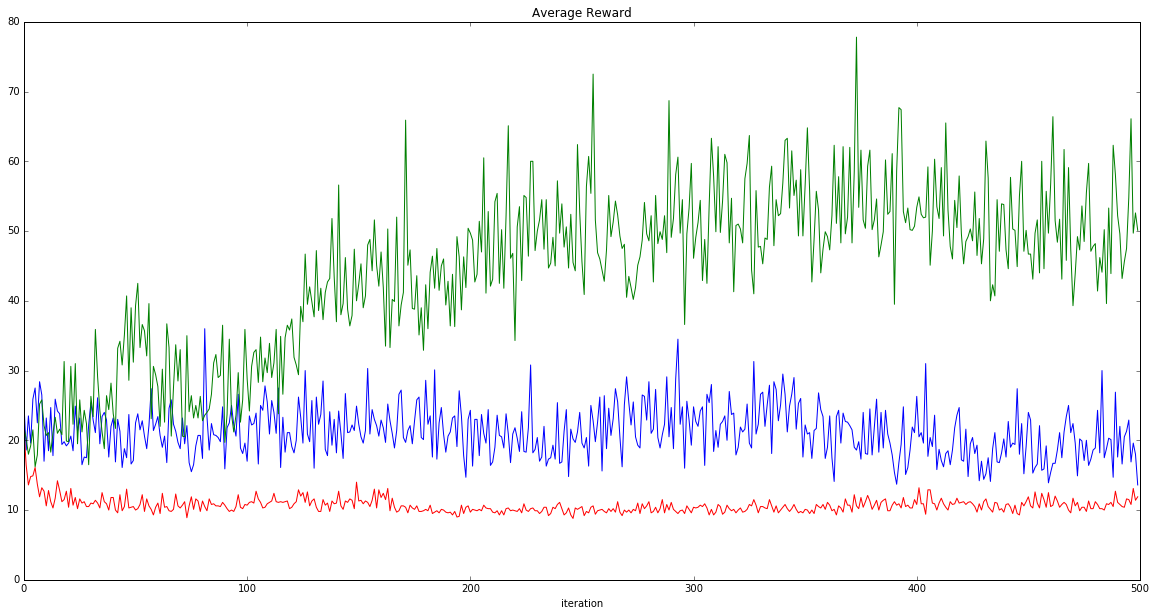

In [161]:
import gym
import time
%matplotlib inline 
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
ops.reset_default_graph()
rews = []
for lr in [0.01,0.05,0.1]:

    env = gym.make('CartPole-v0')
    learning_rate = lr
    opt = tf.train.AdamOptimizer
    opt_value = tf.train.AdamOptimizer
    rf = ReinforceAgent(env,learning_rate=learning_rate,optimizer=opt,value_optimizer=opt_value)
    rewards = []
    for i in xrange(500):
        
        states,actions,advantages,total_reward = rf.create_trajectory(env,gamma=0.99,horizon=200)
        rf.sess.run(rf.optimizer, feed_dict={rf.state: states, rf.action: actions, rf.adv: advantages})
        #Value
        states,actions,advantages,total_reward = rf.create_trajectories(env,gamma=0.99,horizon=200,T=10)
        rf.sess.run(rf.value_optimizer,feed_dict={rf.state_value: states, rf.value_actual: advantages})
        
        rewards.append(np.mean(total_reward))
        if i%100==0:
            print i,total_reward
    rews.append(rewards)

#Plotting the results
plt.figure(figsize=(20,10)) 
f, axarr = plt.subplots(1,figsize=(20,10))
axarr.plot(rews[0])
axarr.plot(rews[1])
axarr.plot(rews[2])
axarr.set_title('Average Reward')
axarr.set_xlabel("iteration")

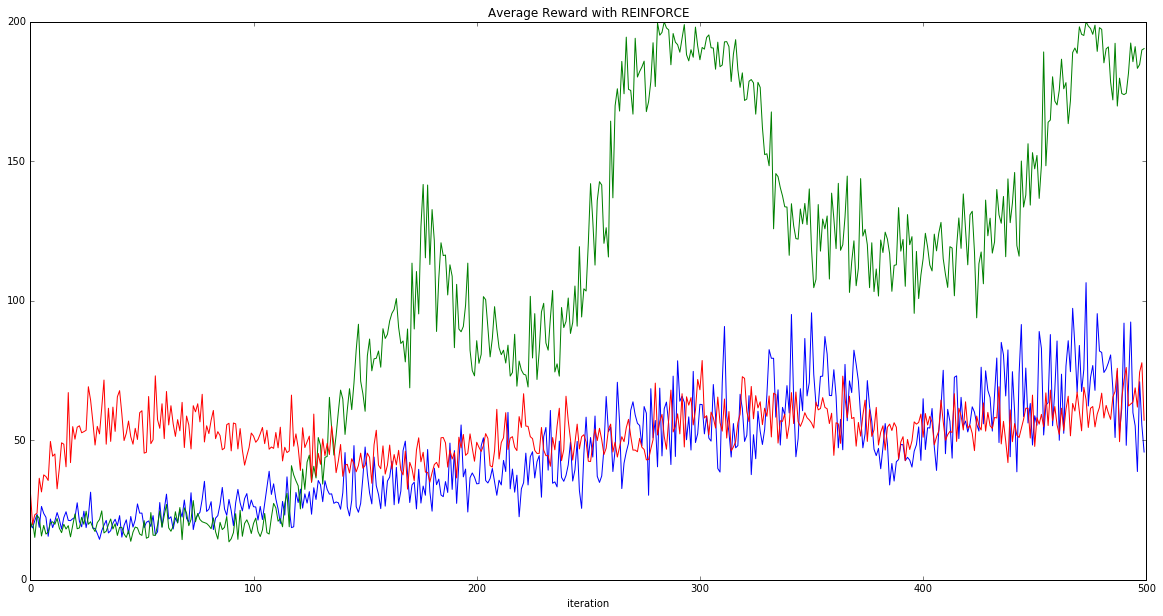

In [153]:
#Plotting the results
plt.figure(figsize=(20,10)) 
f, axarr = plt.subplots(1,figsize=(20,10))
axarr.plot(rews[0])
axarr.plot(rews[1])
axarr.plot(rews[2])
axarr.set_title('Average Reward with REINFORCE')
axarr.set_xlabel("iteration")

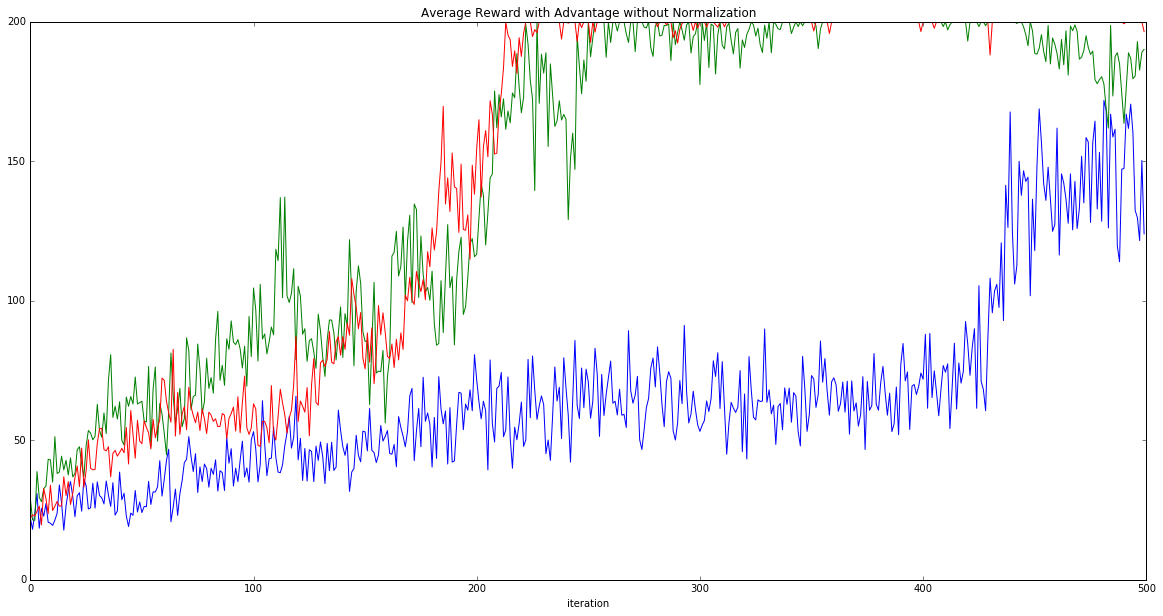

In [146]:
#Plotting the results with Baseline
plt.figure(figsize=(20,10)) 
f, axarr = plt.subplots(1,figsize=(20,10))
axarr.plot(rews[0])
axarr.plot(rews[1])
axarr.plot(rews[2])
axarr.set_title('Average Reward with Advantage without Normalization')
axarr.set_xlabel("iteration")

In [40]:
a.index(1)

0

In [86]:
for i in xrange(len([1,2,3,4,5]) - 1, -1, -1):
    print i 

4
3
2
1
0
